In [ ]:
import numpy as np
from sklearn import datasets
from scipy.spatial.distance import squareform, pdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

In [ ]:
'''
referencing https://code.activestate.com/recipes/215912-union-find-data-structure/ 
'''

class UnionFind:
    def __init__(self):
        '''
        Create an empty union find data structure.
        '''
        self.num_weights = {}
        self.parent_pointers = {}
        self.num_to_objects = {}
        self.objects_to_num = {}
        self.__repr__ = self.__str__

    def insert_objects(self, objects):
        '''
        Insert a sequence of objects into the structure.  
        All must be Python hashable.
        '''
        for object in objects:
            self.find(object);
        
    def find(self, object):
        '''
        Find the root of the set that an object is in.
        If the object was not known, will make it known, and it becomes its own set.
        Object must be Python hashable.
        '''
        if not object in self.objects_to_num:
            obj_num = len(self.objects_to_num)
            self.num_weights[obj_num] = 1
            self.objects_to_num[object] = obj_num
            self.num_to_objects[obj_num] = object
            self.parent_pointers[obj_num] = obj_num
            return object
        stk = [self.objects_to_num[object]]
        par = self.parent_pointers[stk[-1]]
        while par != stk[-1]:
            stk.append(par)
            par = self.parent_pointers[par]
        for i in stk:
            self.parent_pointers[i] = par
        return self.num_to_objects[par]
  
    def union(self, object1, object2):
        '''
        Combine the sets that contain the two objects given.
        Both objects must be Python hashable.
        If either or both objects are unknown, will make them known, and combine them.
        '''
        o1p = self.find(object1)
        o2p = self.find(object2)
        if o1p != o2p:
            on1 = self.objects_to_num[o1p]
            on2 = self.objects_to_num[o2p]
            w1 = self.num_weights[on1]
            w2 = self.num_weights[on2]
            if w1 < w2:
                o1p, o2p, on1, on2, w1, w2 = o2p, o1p, on2, on1, w2, w1
            self.num_weights[on1] = w1+w2
            del self.num_weights[on2]
            self.parent_pointers[on2] = on1

    def __str__(self):
        '''
        Included for testing purposes only.
        All information needed from the union find data structure can be attained using find.
        '''
        sets = {}
        for i in xrange(len(self.objects_to_num)):
            sets[i] = []
        for i in self.objects_to_num:
            sets[self.objects_to_num[self.find(i)]].append(i)
        out = []
        for i in sets.itervalues():
            if i:
                out.append(repr(i))
        return ', '.join(out)

In [ ]:
class Points:
  def __init__(self, points, labels):
      self.points = points
      self.labels = labels

In [ ]:
def generate_edges(X, metric):
  # generate edges using scipy
  dist = squareform(pdist(X, metric))
  mst = minimum_spanning_tree(dist).toarray()

  edges = []

  for i in range(len(mst)):
    for j in range(len(mst[0])):
      if mst[i][j] != 0:
        edges.append((mst[i][j], i, j))

  edges.sort(key=lambda x: x[0])

  return edges

def generate_placement(edges):
  uf = UnionFind()
  clusters = {}

  for edge in edges:
    # find cluster number of current connecting points
    c1 = uf.find(edge[1])
    c2 = uf.find(edge[2])

    if c1 not in clusters:
      if c2 not in clusters:
        # two new points, just put them along y axis
        rst = Points(np.array([[0., -edge[0]/2], [0., edge[0]/2]]), 
                     np.array([edge[1], edge[2]]))
      else: 
        # c2 in existing cluster, rotate and translate the cluster and c1
        points2 = rotate_points(clusters[c2], edge[2])
        rst = translate_points(Points(np.array([[0., 0.]]), np.array([edge[1]])), points2, edge[0])
    else:
      if c2 not in clusters:
        # c1 in existing cluster, rotate and translate the cluster and c2
        points1 = rotate_points(clusters[c1], edge[1])
        rst = translate_points(points1, Points(np.array([[0., 0.]]), np.array([edge[2]])), edge[0])
      else:
        # both in existing clusters, roate and translate the clusters
        points1 = rotate_points(clusters[c1], edge[1])
        points2 = rotate_points(clusters[c2], edge[2])
        rst = translate_points(points1, points2, edge[0])

    uf.union(edge[1], edge[2])

    c = uf.find(edge[1])
    clusters[c] = rst

  # return placement
  return clusters[uf.find(edges[0][1])]

In [ ]:
def get_rot(point1, point2):
  # calculate rotation matrix from two points
  theta = np.arctan((point1[0]-point2[0])/(point1[1]-point2[1]))

  return np.array([[np.cos(theta), -np.sin(theta)], 
                   [np.sin(theta), np.cos(theta)]])

def rotate_points(points_labels, other):
  # unwrap points
  points = points_labels.points
  labels = points_labels.labels

  # do not need to rotate when there are only 2 points
  if len(points) == 2:
    return points_labels

  # translate points to centering at (0, 0)
  center = np.sum(points, axis=0)/len(points)
  points -= center

  # treat the connecting point as center
  for i in range(len(labels)):
    if labels[i] == other:
      center = points[i]
      break

  # find a line of the hull that is cloest to the center
  hull = ConvexHull(points)
  min_dis = float('inf')
  for simplice in hull.simplices:
    point1 = points[simplice[0]]
    point2 = points[simplice[1]]
    d = np.abs(np.cross(point2-point1, center-point1)/np.linalg.norm(point2-point1))
    if d < min_dis:
      min_dis = d
      min_pair = simplice

  # get the rotate matrix using the line
  rot = get_rot(points[min_pair[0]], points[min_pair[1]])

  # rotate and tanslate points 
  # so that points on the line are on y-axis and symmetric along x-axis
  rst = (rot@points.T).T
  rst[:, 0] -= rst[min_pair[0]][0]
  rst[:, 1] -= (rst[min_pair[0]][1] + rst[min_pair[1]][1])/2
  
  return Points(rst, labels)

def translate_points(Points1, Points2, distance):
  # unwrap points
  points1 = Points1.points
  points2 = Points2.points

  # place points1 at left side of y-axis
  if np.sum(points1[:, 0]) > 0:
    points1[:, 0] = -points1[:, 0]
  points1[:, 0] -= distance/2

  # place points2 at right side of y-axis
  if np.sum(points2[:, 0]) < 0:
    points2[:, 0] = -points2[:, 0]
  points2[:, 0] += distance/2

  return Points(np.concatenate((points1, points2), axis=0), np.concatenate((Points1.labels, Points2.labels)))

In [ ]:
def topomap(X, y, filename, metric='euclidean'):
  edges = generate_edges(X, metric)
  placement = generate_placement(edges)

  fig, ax = plt.subplots()

  ax.scatter(placement.points[:, 0], placement.points[:, 1], c=y[placement.labels])

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.savefig(filename)
  plt.show()
  

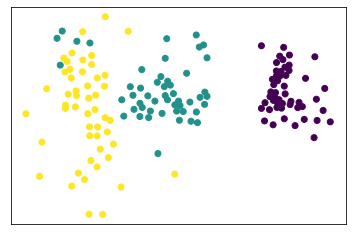

In [ ]:
iris = datasets.load_iris()
topomap(iris.data, iris.target, "iris")

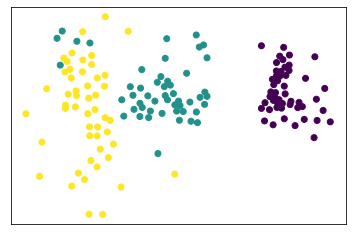

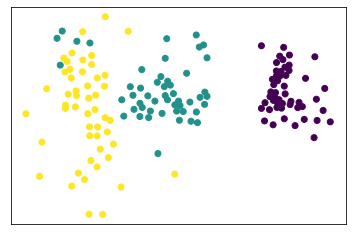

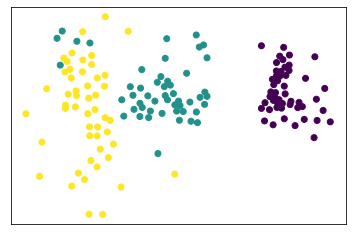

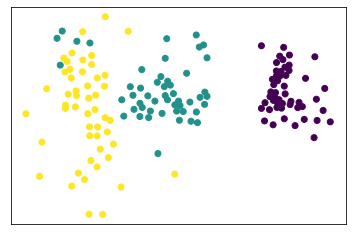

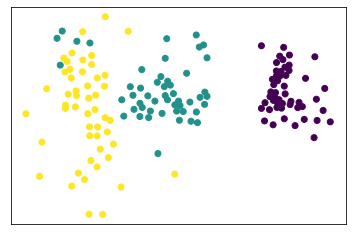

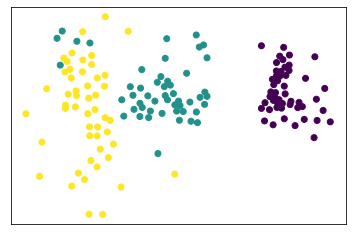

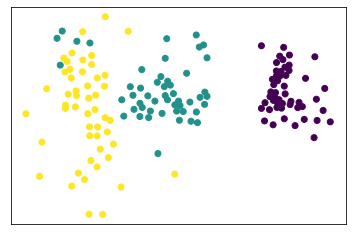

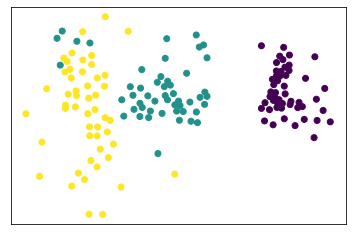

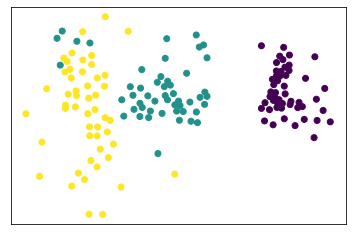

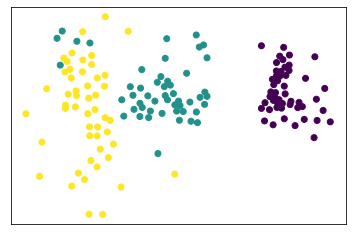

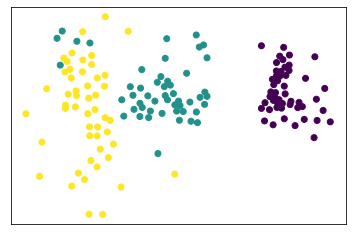

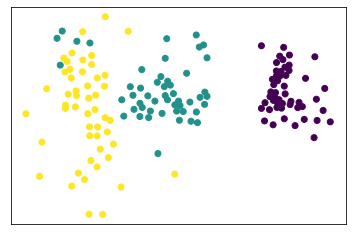

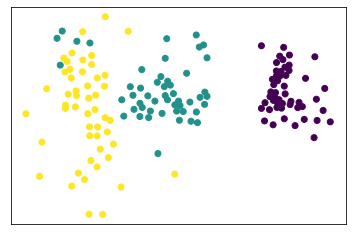

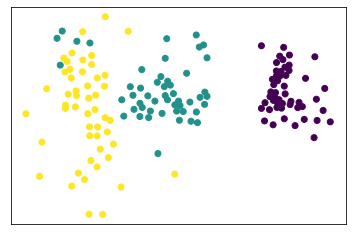

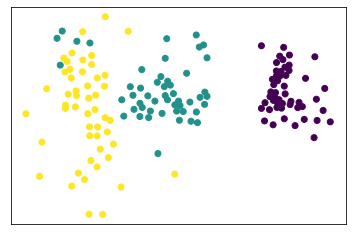

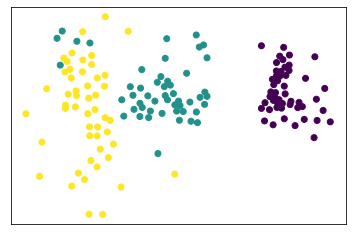

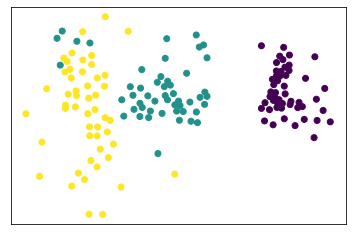

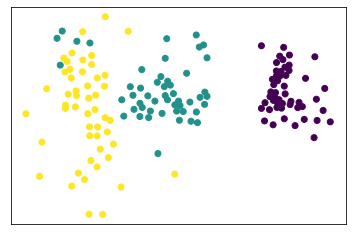

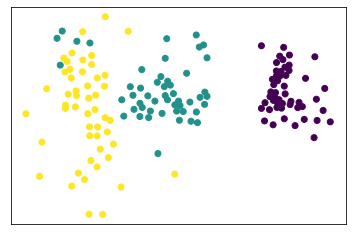

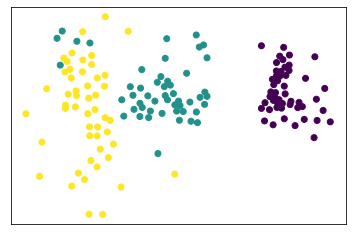

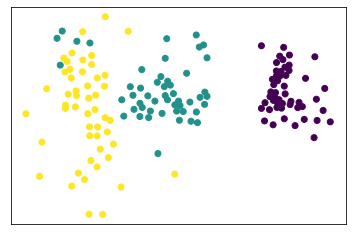

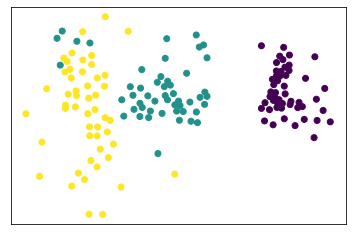

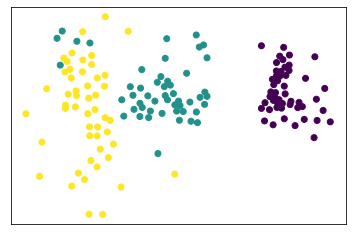

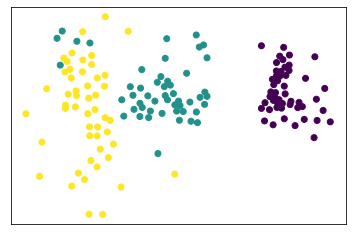

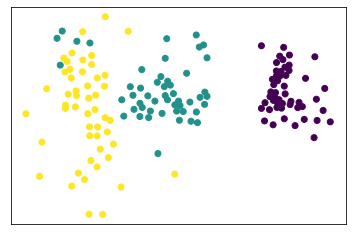

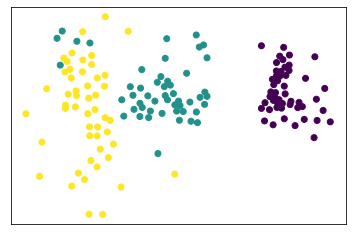

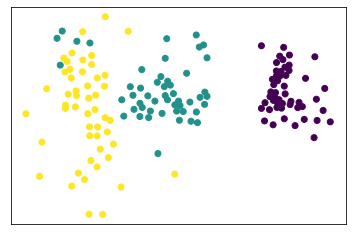

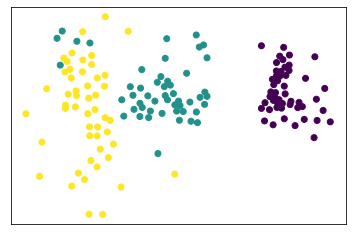

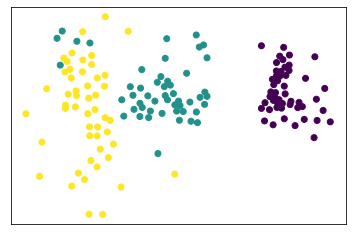

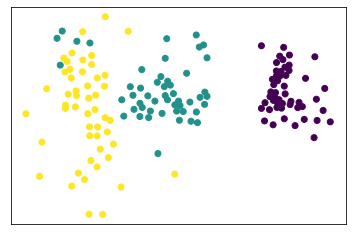

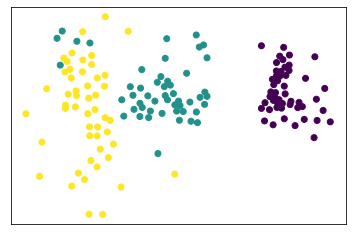

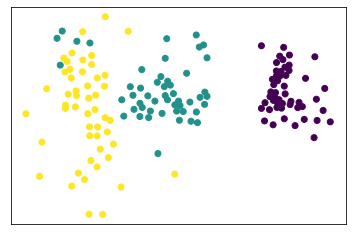

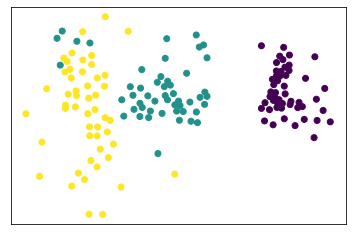

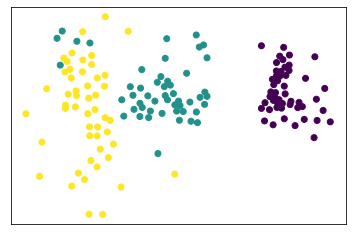

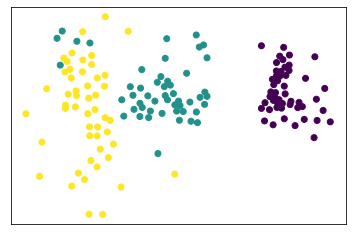

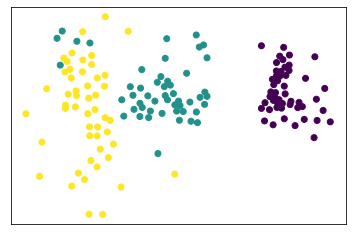

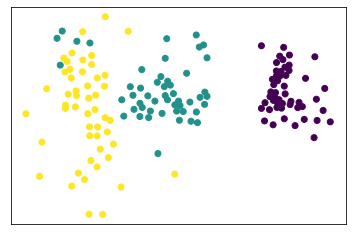

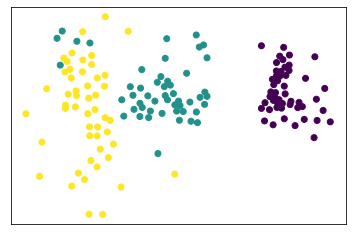

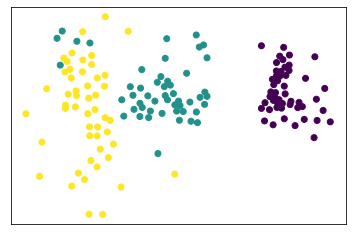

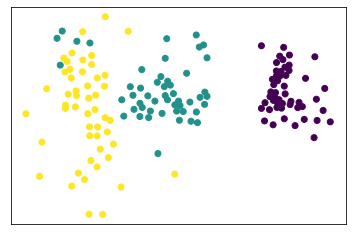

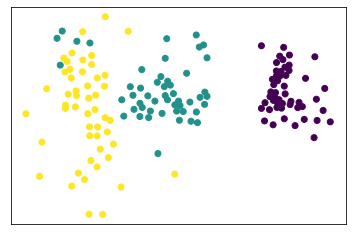

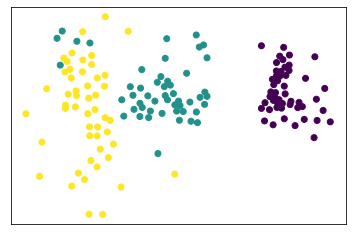

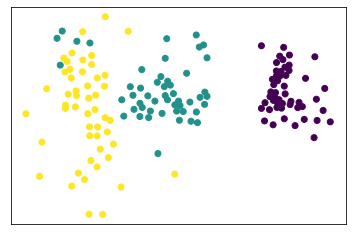

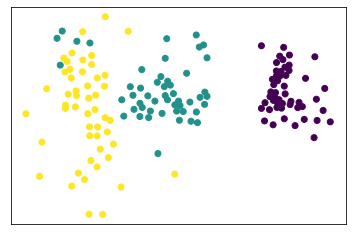

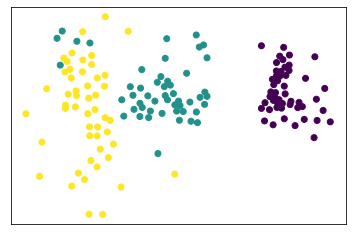

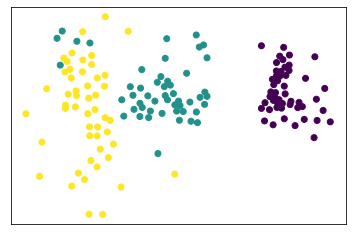

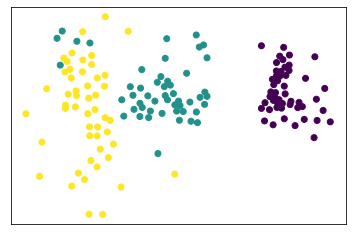

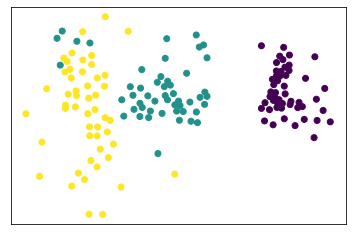

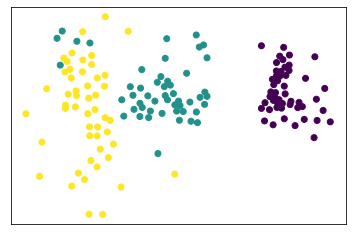

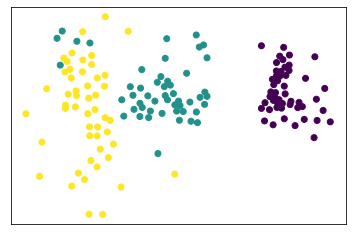

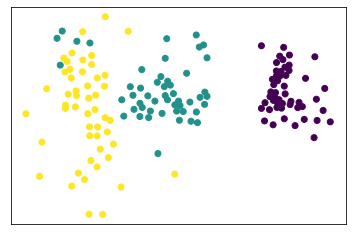

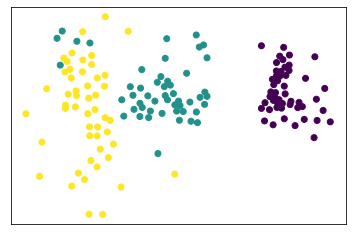

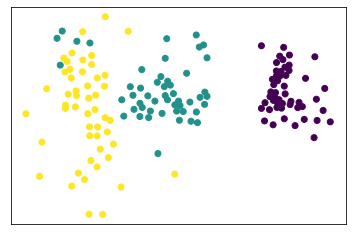

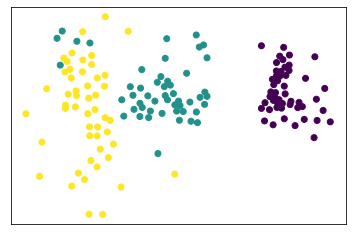

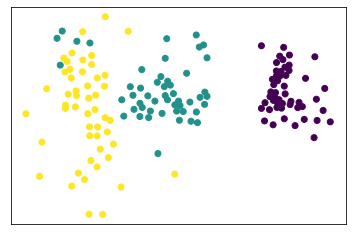

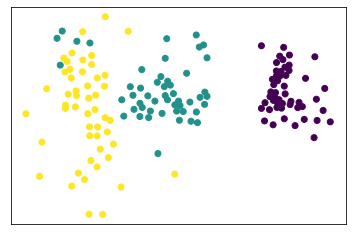

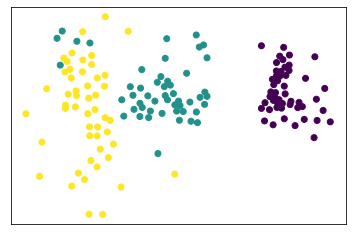

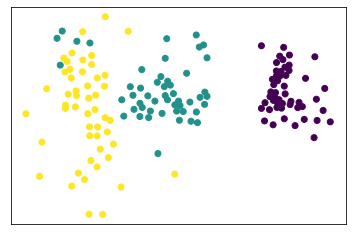

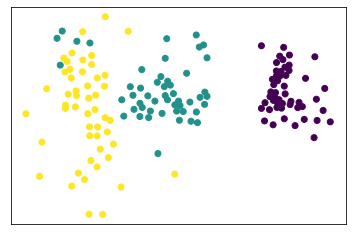

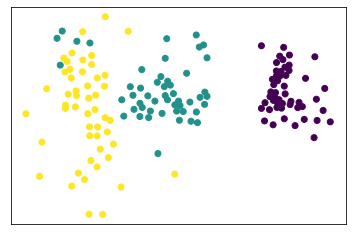

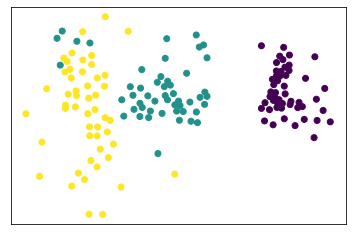

10 loops, best of 5: 171 ms per loop


In [ ]:
%%timeit
topomap(iris.data, iris.target, "iris")

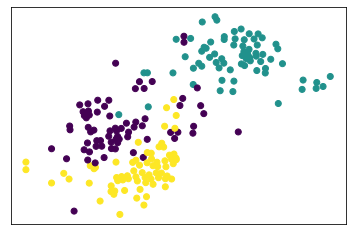

In [ ]:
seeds = datasets.fetch_openml('seeds')
topomap(seeds.data, np.array(seeds.target.values, dtype=int), "seeds")

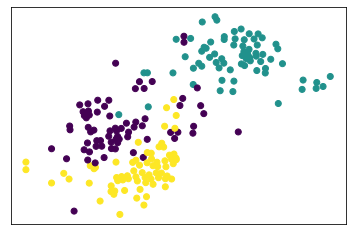

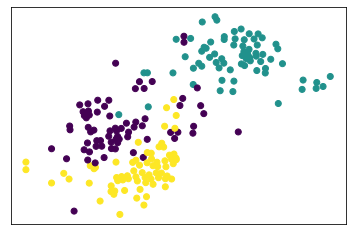

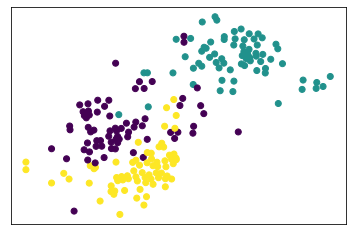

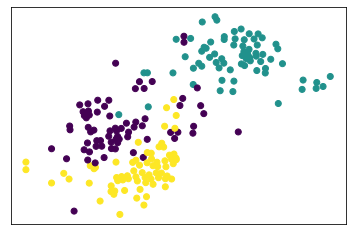

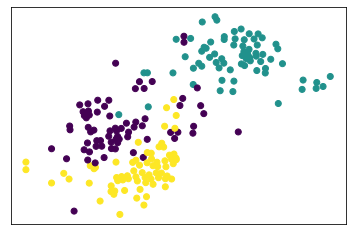

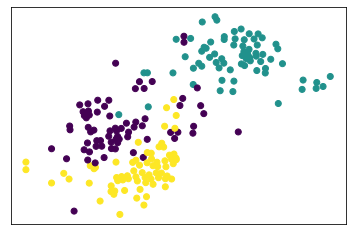

1 loop, best of 5: 208 ms per loop


In [ ]:
%%timeit
topomap(seeds.data, np.array(seeds.target.values, dtype=int), "seeds")

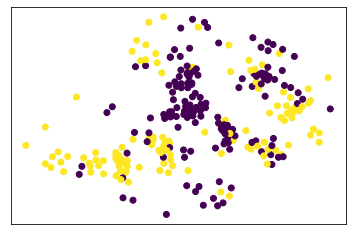

In [ ]:
heart = datasets.fetch_openml('heart')
topomap(heart.data.toarray(), np.array(heart.target), "heart")

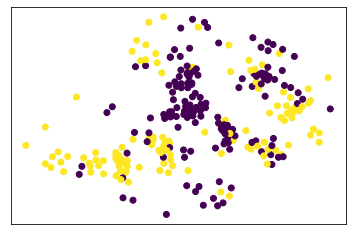

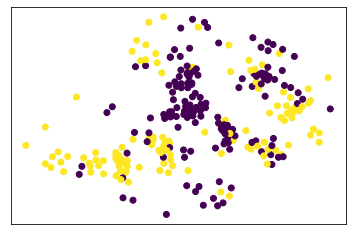

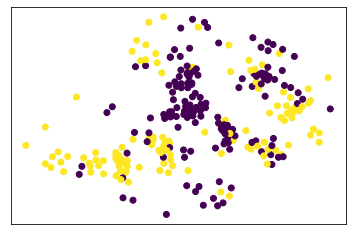

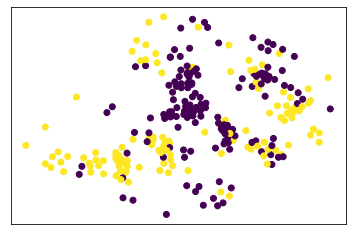

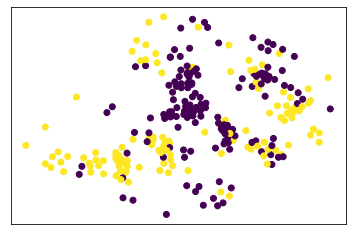

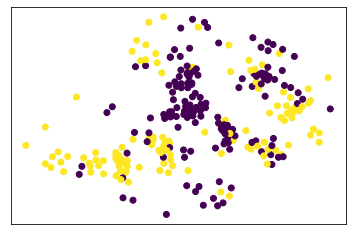

1 loop, best of 5: 262 ms per loop


In [ ]:
%%timeit
topomap(heart.data.toarray(), np.array(heart.target), "heart")

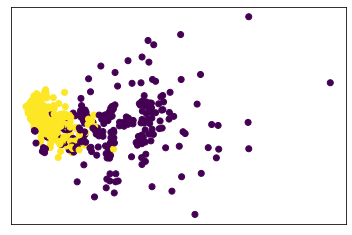

In [ ]:
cancer = datasets.load_breast_cancer()
topomap(cancer.data, cancer.target, "cancer")

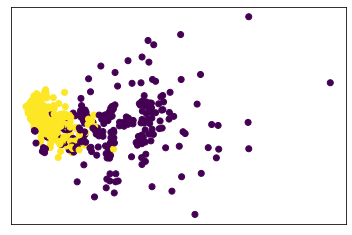

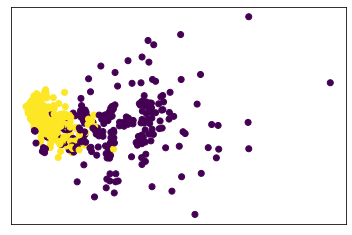

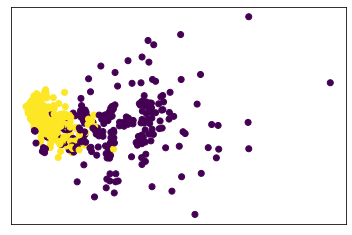

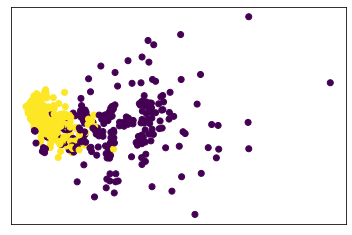

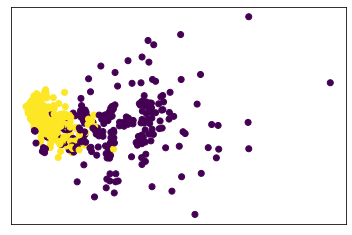

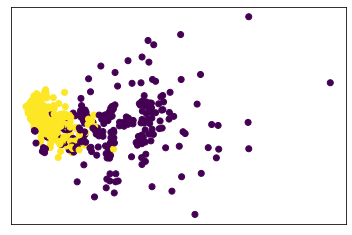

1 loop, best of 5: 589 ms per loop


In [ ]:
%%timeit
topomap(cancer.data, cancer.target, "cancer")

/usr/local/lib/python3.7/dist-packages/sklearn/datasets/_openml.py:421: UserWarning: Multiple active versions of the dataset matching the name mfeat-pixel exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]["version"])


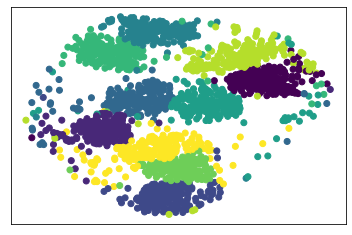

In [ ]:
mfeat = datasets.fetch_openml('mfeat-pixel')
topomap(mfeat.data, np.array(mfeat.target.values, dtype=int), "mfeat")

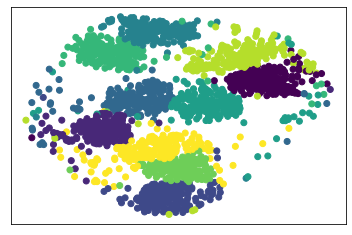

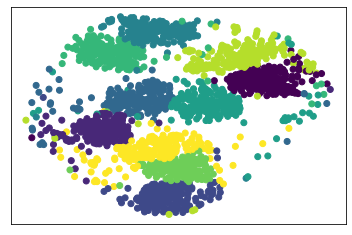

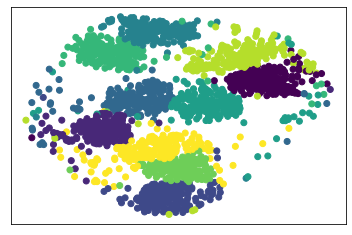

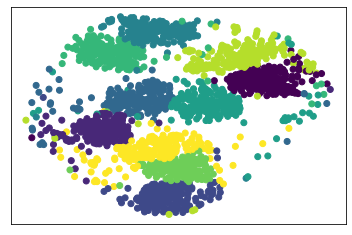

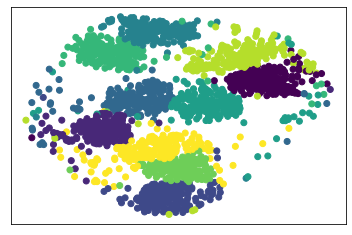

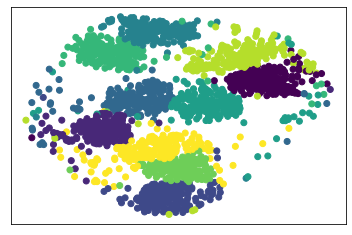

1 loop, best of 5: 4.57 s per loop


In [ ]:
%%timeit
topomap(mfeat.data, np.array(mfeat.target.values, dtype=int), "mfeat")

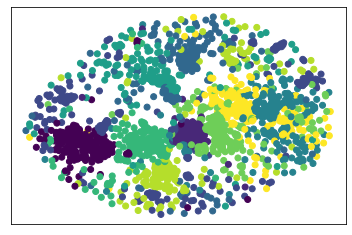

In [8]:
mnist = datasets.fetch_openml('mnist_784')
topomap(mnist.data[:2000], np.array(mnist.target.values, dtype=int)[:2000], "mnist")

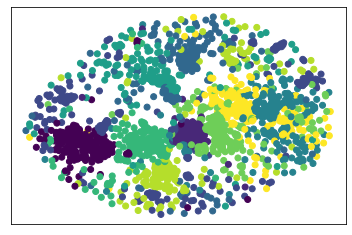

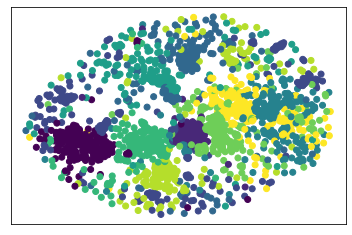

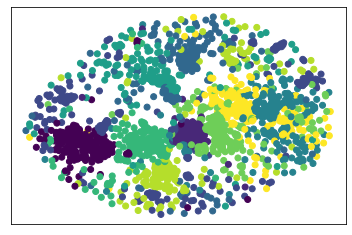

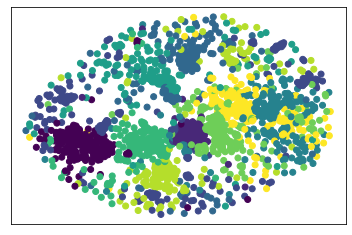

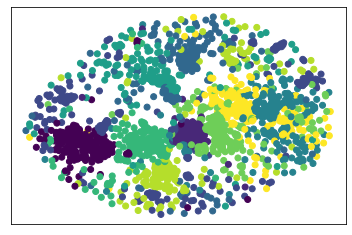

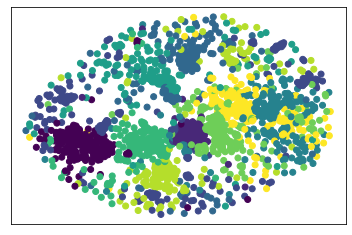

1 loop, best of 5: 6.08 s per loop


In [9]:
%%timeit
topomap(mnist.data[:2000], np.array(mnist.target.values, dtype=int)[:2000], "mnist")

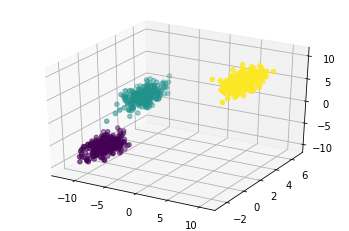

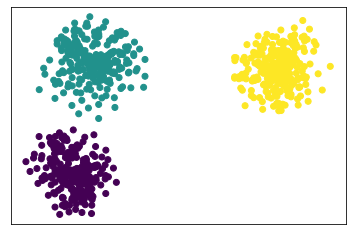

In [ ]:
blob_X, blob_y = datasets.make_blobs(n_samples=800, n_features=3, random_state=2022)

ax = plt.axes(projection ="3d")
ax.scatter3D(blob_X[:, 0], blob_X[:, 1], blob_X[:, 2], c=blob_y)

plt.savefig("normals")
plt.show()

topomap(blob_X, blob_y, "normal")

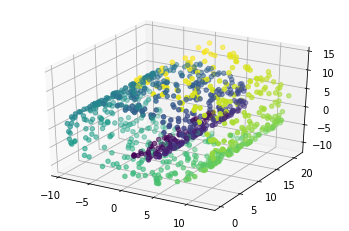

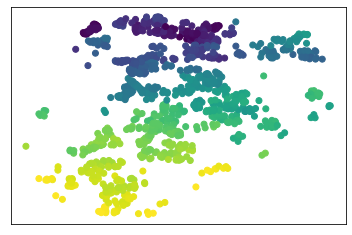

In [ ]:
roll_X, roll_y = datasets.make_swiss_roll(n_samples=1000, random_state=2022)

ax = plt.axes(projection ="3d")
ax.scatter3D(roll_X[:, 0], roll_X[:, 1], roll_X[:, 2], c=roll_y)

plt.savefig("swiss_roll")
plt.show()

topomap(roll_X, roll_y, "roll")